To complete the exercise focus on the parts that are mentioned in questions. You don't need to understand everything to its fullest here. Even if it's nice to know. The following file loads the english/german sentence pairs and prints out an example of what a pair looks like. Note that for fast training we cut the sentences down to pairs where the english text starts with a personal pronoun and the correspoding form of "to be".

In [65]:
%run ./load_languages.py

Reading lines...
Read 195847 sentence pairs
Trimmed to 11727 sentence pairs
Counting words...
Counted words:
eng 7046
ger 4484
['Ich bin zutiefst in dich verliebt.', "I'm deeply in love with you."]


<Figure size 432x288 with 0 Axes>

In [66]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [67]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src), tgt)
    
    def encode(self, src):
        return self.encoder(self.src_embed(src))
    
    def decode(self, memory, tgt):
        return self.decoder(self.tgt_embed(tgt), memory)

class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [68]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([module for _ in range(N)])

In [69]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        "Pass the input through each layer in turn."
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [70]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features)).to(device)
        self.b_2 = nn.Parameter(torch.zeros(features)).to(device)
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [71]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [72]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = [SublayerConnection(size, dropout) for i in range(2)]
        self.size = size

    def forward(self, x):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

In [73]:
class Decoder(nn.Module):
    "Generic N layer decoder"
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory):
        for layer in self.layers:
            x = layer(x, memory)
        return self.norm(x)

In [74]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x
        , mask=subsequent_mask(x.shape[-2])))
        x = self.sublayer[1](x, lambda x: self.src_attn(m, m, x))
        return self.sublayer[2](x, self.feed_forward)

**Exercise 1a)** Complete the attention method

In [75]:
def attention(value, key, query, mask = None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    # fill in the gaps
    d_k = key.shape[3]
    # what is inside the softmax
    #print(value.shape, key.shape, query.shape)
    scores = torch.matmul(query, torch.transpose(key, 2, 3)) / np.sqrt(d_k)
    
    if mask is not None:
        # change all the values where the mask equals 0 to minus infinity (-1e9 is enough)
        scores = scores.masked_fill((mask == 0).to(device), -1e9)  
    # apply softmax to the right dimension
    p_attn = nn.Softmax(dim=1)(scores)
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    # multiply with value
    attention = torch.matmul(p_attn, value)
    
    return attention, p_attn



In [76]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, value, key, query, mask = None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        value, key, query = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (value, key, query))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(value, key, query, mask=mask, 
                                 dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

**Exercise 1d)** Visualize the mask and explain what it does

In [77]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [78]:
subsequent_mask(6)

tensor([[[ True, False, False, False, False, False],
         [ True,  True, False, False, False, False],
         [ True,  True,  True, False, False, False],
         [ True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True]]])

**Result 1d):**<br>
The mask results in the upper right values over the diagonal to be set to "-inf".<br>
This is needed, so that the masked self-attention in the decoder does not get information on future words in the same batch during training, that it should not be having information about. <br>
The Trues in the lower left corner stand for the prior words, that the decoder should have information about.

In [79]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


In [80]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class PositionalEncoding(nn.Module):
    "Implements the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [81]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    print(tgt_vocab)
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [82]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    # converts a string into a tensor
    # the options for lang are either input_lang or output_lang
    indexes = indexesFromSentence(lang, sentence)
    sen_len = len(indexes)
    # fill the tensor with EOS_tokens at the end, s.t. it has length 10
    indexes.extend([EOS_token for _ in range(10-sen_len)])
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    input_tensor = input_tensor.permute(1,0)
    target_tensor = target_tensor.permute(1,0)
    return (input_tensor, target_tensor)

def outputTensorFromTGT(tgt):
    # converts the tgt to an output tensor, with which we can compute the loss
    # think about what happens here. 4484 =  output_lang.n_words is the number of german words in our dictionary
    tgt_list = []
    bs = tgt.shape[0]
    for i in range(bs):
        sentdist_tensor = torch.cat([torch.from_numpy(np.eye(1,output_lang.n_words,index.item())).unsqueeze(0)
                           for index in tgt[i,:]], dim = 1)
        tgt_list.append(sentdist_tensor)
    return torch.cat(tgt_list, dim = 0).float()

  
  
  

def train(pair, batch_size, sample = False):
    src, tgt = pair
    src.to(device)
    tgt.to(device)
    tgt_tensor = outputTensorFromTGT(tgt).to(device)
    decoder_input = torch.tensor([[SOS_token] for _ in range(batch_size)], device=device)
    if not sample:
        decoder_input = torch.cat([decoder_input, tgt], dim = 1)
    else:
        cat_list = [decoder_input]
        gen_list = []
    memory = transformer.encode(src)
    if sample:
        for i in range(MAX_LENGTH):
            decoder_output = transformer.decode(memory, decoder_input)
            gen = transformer.generator(decoder_output[:,-1])
            gen_list.append(gen.unsqueeze(1))
            pred = (gen.argmax(dim = 1)).unsqueeze(1)
            cat_list.append(pred)
            decoder_input = torch.cat(cat_list, dim = 1)
        output = torch.cat(gen_list, dim = 1)
    else:
        decoder_output = transformer.decode(memory, decoder_input)
        gen = transformer.generator(decoder_output[:,:10,:])
        output = gen
    loss = criterion(output, tgt_tensor)
    return loss, decoder_input

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


transformer = make_model(input_lang.n_words, output_lang.n_words, 2 , d_model = 512, d_ff = 512, h = 4)
transformer.to(device)

optimizer = optim.Adam(transformer.parameters())
criterion = nn.KLDivLoss(reduction = 'batchmean')

n_pairs = 64000 # number of training pairs
batch_size = 512 

#--------------
# Create Batch
#--------------


training_pairs = []
for i in range(n_pairs // batch_size):
    batch_pairs = [tensorsFromPair(random.choice(pairs)) for _ in range(batch_size)] 
    batch_input  = torch.cat([pair[0] for pair in batch_pairs], dim = 0)
    batch_tgt = torch.cat([pair[1] for pair in batch_pairs], dim = 0)
    training_pairs.append((batch_input, batch_tgt))


4484


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [84]:
def evaluate(pair, showTgt = False, print_ = True):
    transformer.eval()      # disable dropout
    inputs = tensorsFromPair(pair)
    if print_:
        print("Example: Input -> Output:")
        print(pair[0])
        output_sent ='> '
        if showTgt:
              print('- '+pair[1])
    else:
        output_sent = ''
    _ , output = train(inputs, batch_size = 1, sample = True)
    
    for word in output.squeeze(0):
        if(word.item() == EOS_token):
            # don't print EOS at the end
            break
        if(word.item() != SOS_token):
            # don't print SOS at the beginning
            output_sent += output_lang.index2word[word.item()]+' '
    return (output_sent)

**Exercise 1a)** Train the Transformer for 5 epochs. (10 Epochs used here)

[Epoch: 1][25/125][Loss: 39.50674057006836][Time per epoch: 00:01:41]
Example: Input -> Output:
Ich mache das nicht wegen dem Geld.
> I'm I'm I'm I'm I'm 
[Epoch: 1][50/125][Loss: 29.56402015686035][Time per epoch: 00:01:41]
Example: Input -> Output:
Ich bin auch hier.
> not not not to to to to to to to 
[Epoch: 1][75/125][Loss: 26.092172622680664][Time per epoch: 00:01:41]
Example: Input -> Output:
Du bist so ein Feigling!
> I'm not a a a a you. 
[Epoch: 1][100/125][Loss: 22.278085708618164][Time per epoch: 00:01:41]
Example: Input -> Output:
Sie ist ein sehr schüchternes Mädchen.
> I am a a a a a a a a 
[Epoch: 1][125/125][Loss: 16.4414005279541][Time per epoch: 00:01:41]
Example: Input -> Output:
Du bist unbegabt.
> You're a good good good good good good good good 
[Epoch: 2][25/125][Loss: 10.861800193786621][Time per epoch: 00:01:42]
Example: Input -> Output:
Ich bin viel größer als Tom.
> I'm taller than I am. 
[Epoch: 2][50/125][Loss: 7.257593631744385][Time per epoch: 00:01:41]


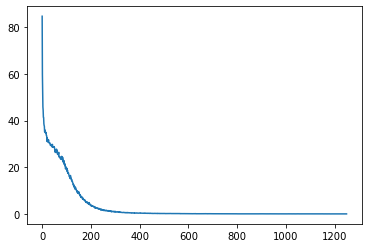

In [85]:
import time


start_time = time.time()
def timer(progress, iterations):
    now = time.time()-start_time
    now = now*iterations/progress
    std = now // 3600
    min = (now // 60) % 60
    sec = now % 60
    return int(std), int(min), int(sec)


total_loss = 0
log = 25       # when to show training status
epochs = 10     # how many epochs to train
losses = []
for epoch in range(epochs):
    for i,pair in enumerate(training_pairs):
        transformer.train()
        optimizer.zero_grad()
        loss, _ = train(pair, batch_size = batch_size)
        loss.backward()
        optimizer.step()
        total_loss += loss
        losses.append(loss)
        if i% log == log-1:
            print("[Epoch: {}][{}/{}][Loss: {}][Time per epoch: {:02d}:{:02d}:{:02d}]".format(
                epoch+1, i+1, int(n_pairs/batch_size), total_loss/log, *timer(i+1,int(n_pairs/batch_size))))
            total_loss = 0
            pair = random.choice(pairs)
            print(evaluate(pair))
    start_time = time.time()
print('Loss plot:')
plt.plot(losses)
plt.show()


In [86]:
pair = random.choice(pairs)
print(evaluate(pair, showTgt = True))

Example: Input -> Output:
Du bist beharrlich.
- You're persevering.
> You're persevering. 


**Exercise 1b)** Understand input and output: Print the shape of the input and output and explain
what each dimension stands for. How does the KL-Divergence compute the loss for the
output? Think about how the tensor represents a probability distribution.

In [87]:
pair = random.choice(pairs)
transformer.eval()      # disable dropout
inputs = tensorsFromPair(pair)
print("Input Shapes: (Sequence:",inputs[0].shape, ",Target:",inputs[1].shape,")")
print("The first dimension is the batch size, the second dimension is the maximal sentence length.")
_ , output = train(inputs, batch_size = 1, sample = True)
print("Output Shape:",output.shape)
print("The first dimension is the batch size, the second dimension is the sentence length.")

Input Shapes: (Sequence: torch.Size([1, 10]) ,Target: torch.Size([1, 10]) )
The first dimension is the batch size, the second dimension is the maximal sentence length.
Output Shape: torch.Size([1, 11])
The first dimension is the batch size, the second dimension is the sentence length.


In [88]:
sample=False
src, tgt = inputs
src.to(device)
tgt.to(device)
tgt_tensor = outputTensorFromTGT(tgt).to(device)
decoder_input = torch.tensor([[SOS_token] for _ in range(1)], device=device)
if not sample:
    decoder_input = torch.cat([decoder_input, tgt], dim = 1)
else:
    cat_list = [decoder_input]
    gen_list = []
memory = transformer.encode(src)
if sample:
    for i in range(MAX_LENGTH):
        decoder_output = transformer.decode(memory, decoder_input)
        gen = transformer.generator(decoder_output[:,-1])
        gen_list.append(gen.unsqueeze(1))
        pred = (gen.argmax(dim = 1)).unsqueeze(1)
        cat_list.append(pred)
        decoder_input = torch.cat(cat_list, dim = 1)
    output = torch.cat(gen_list, dim = 1)
else:
    decoder_output = transformer.decode(memory, decoder_input)
    gen = transformer.generator(decoder_output[:,:10,:])
    output = gen
print("Output Shape:",output.shape)
print("Target Shape:",tgt_tensor.shape)
print("The Inputs for the KL-Divergence loss criterion are of size:")
print("    (batchsize, sentence-length, softmax distribution over tokens)")
print("So the KL_Divergence looks at the difference in token-distributions between output and target.")
#loss = criterion(output, tgt_tensor)

Output Shape: torch.Size([1, 10, 4484])
Target Shape: torch.Size([1, 10, 4484])
The Inputs for the KL-Divergence loss criterion are of size:
    (batchsize, sentence-length, softmax distribution over tokens)
So the KL_Divergence looks at the difference in token-distributions between output and target.


**Exercise 1c)** Translate your own german sentence. You can make use of the evaluate function to achive that.

In [89]:
pair = ["Du bist sauer.", "You are angry."]
print(evaluate(pair, showTgt = True))

Example: Input -> Output:
Du bist sauer.
- You are angry.
> You're a little mad at you. 


**Exercise 2a)** Print the distance from your word to sister in embedding space 

In [90]:
word1 = "woman"
word2 = "man"
word3 = "brother"
word4 = "sister"

In [91]:
word1_embed = transformer.tgt_embed(tensorFromSentence(output_lang, word1))
word2_embed = transformer.tgt_embed(tensorFromSentence(output_lang, word2))
word3_embed = transformer.tgt_embed(tensorFromSentence(output_lang, word3))
word4_embed = transformer.tgt_embed(tensorFromSentence(output_lang, word4))
word1_embed.shape

torch.Size([10, 1, 512])

In [92]:
calc_embed = word3_embed - word2_embed + word1_embed
print(calc_embed.shape,word4_embed.shape)
torch.sum((calc_embed - word4_embed)**2)

torch.Size([10, 1, 512]) torch.Size([10, 1, 512])


tensor(1185.0962, device='cuda:0', grad_fn=<SumBackward0>)

**Result 2a):** The Euclidean distance seems to be quite large between the two Embeddings. (But is got smaller by about 600 by changing the epochs from 5 to 10)

**Exercise 2b)** Complete the following code. Be aware that there will be 10 values for each word even if the input sentence is shorter than 10 words. Thats because the sentences get filled with EOS_tokens at the end such that they all are the same size. Set the tick_label of the bar plot to be the input sentences words (use string.split() to convert strings to lists).

In [93]:
transformer.decoder.layers[0]

DecoderLayer(
  (self_attn): MultiHeadedAttention(
    (linears): ModuleList(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (src_attn): MultiHeadedAttention(
    (linears): ModuleList(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward): PositionwiseFeedForward(
    (w_1): Linear(in_features=512, out_features=512, bias=True)
    (w_2): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sublayer): Mod

In [94]:
transformer.decoder.layers[0].src_attn.attn[0].shape

torch.Size([4, 10, 10])

Input sentence: Ich bin das zweitälteste von drei Kindern.
Output sentence: I'm the second oldest of three children. 
Word for attention:  second


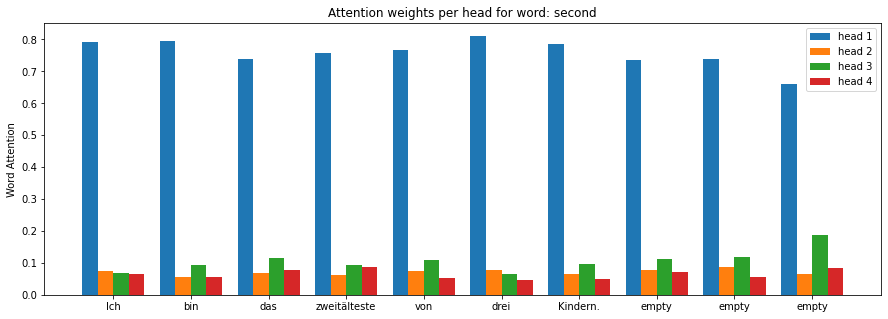

In [95]:
pair = random.choice(pairs)
output = evaluate(pair, showTgt = True, print_ = False)
sentence = pair[0].split()
which_word = 2
output_sentence = output.split()
print('Input sentence: {}'.format(pair[0]))
print('Output sentence: {}'.format(output))
print("Word for attention: ",output_sentence[which_word])
att_tensor = transformer.decoder.layers[0].src_attn.attn[0].data
att_tensor = att_tensor.to('cpu').numpy()
fig, ax = plt.subplots(figsize=(15,5))
x = np.arange(att_tensor.shape[1])
width = 0.2
labels = sentence
for i in range(len(sentence),att_tensor.shape[1]):
    labels.append("empty")

dist = att_tensor[0][which_word]
rects1 = ax.bar(x - 3*width/2, dist, width, label='head 1')
dist = att_tensor[1][which_word]
rects2 = ax.bar(x - width/2, dist, width, label='head 2')
dist = att_tensor[2][which_word]
rects3 = ax.bar(x + width/2, dist, width, label='head 3')
dist = att_tensor[3][which_word]
rects4 = ax.bar(x + 3*width/2, dist, width, label='head 4')
    
ax.set_ylabel('Word Attention')
ax.set_title('Attention weights per head for word: {}'.format(output_sentence[which_word]))
ax.set_xticks(x)
ax.set_xticklabels(sentence)
ax.legend()
plt.show()